# Language Modeling с помощью LSTM

Выполнил: Бычков Георгий 317 группа

В данном ноутбуке реализована LM на базе LSTM, используя посимвольное (character-level) кодирование. Сеть будет обучаться посимвольно по некоторому тексту, а затем генерировать новый текст. Исследуется влияние гиперпараметров на качество генерируемого текста. В качестве функции потерь используется `CrossEntropy`

Концептуально модель можно представить так ([Источник](https://habr.com/ru/post/342738/)):
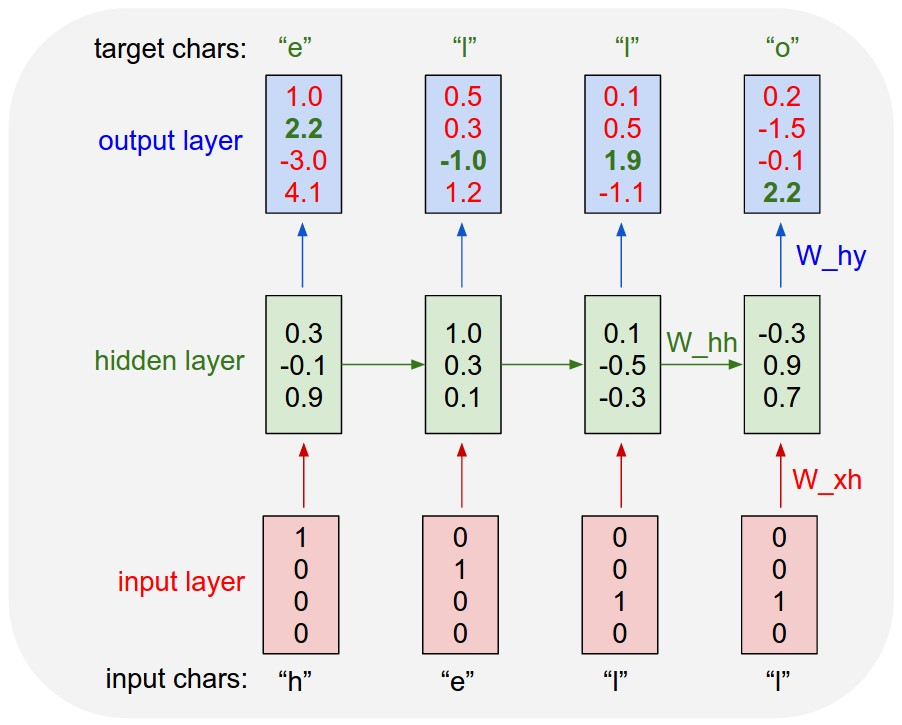

## Подключение библиотек, датасета

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from text_process import *
from model import *
from utils import *
from plotting import *

device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm import tqdm

В качестве корпуса для обучения берется текстовый файл с романом М. А. Шолохова "Поднятая целина", взятый по данной [ссылке](https://all-the-books.ru/books/sholohov-mihail-podnyataya-celina/)

In [2]:
filename = 'podnyataya-celina.txt'

corpus = read_corpus(filename)
corpus[:200]

'михаил шолохов поднятая целина книга первая в конце января, овеянные первой оттепелью, хорошо пахнут вишневые сады. в полдень где нибудь в затишке если пригревает солнце грустный, чуть внятный запах в'

In [3]:
print(f"Число символов в корпусе: {len(corpus)}")
chars, charmap = get_charmap(corpus)
charcount = len(chars)
print(f"Число уникальных символов: {len(chars)}")
corpus_array = map_corpus(corpus, charmap)
print(f"corpus_array.shape: {corpus_array.shape}")

Число символов в корпусе: 1299917
Число уникальных символов: 38
corpus_array.shape: (1299917,)


Обучим начальную сеть

In [6]:
n_hidden = 512
n_layers = 2
drop_prob = 0.7

In [11]:
net = LSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)

In [9]:
n_seqs = 128
n_steps = 100

n_epochs = 25
opt = lambda x: torch.optim.Adam(x)

In [10]:
train_loss, val_loss = train_model(net, corpus_array, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps, opt=opt, device=device)

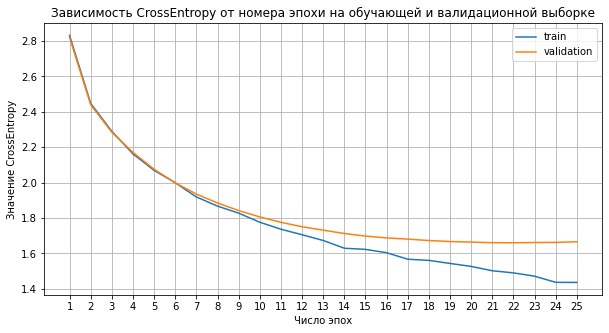

In [12]:
fig = plt.figure(figsize=(10, 5))

x = np.array(range(n_epochs)) + 1
plt.plot(x, train_loss, label='train')
plt.plot(x, val_loss, label='validation')

plt.xlabel('Число эпох')
plt.ylabel('Значение CrossEntropy')
    
plt.xticks(x)

plt.title("Зависимость CrossEntropy от номера эпохи на обучающей и валидационной выборке")
plt.legend()
plt.grid(True)
plt.show()

## Выбор оптимизатора

Попробуем выбрать самый лучший оптимизатор для данной задачи. Проверяем Adam и SGD с разными значениями инерции

In [21]:
optimisers = [lambda x: torch.optim.Adam(x), lambda x: torch.optim.SGD(x, lr=0.1, momentum=0.1), lambda x: torch.optim.SGD(x, lr=0.1, momentum=0.5), lambda x: torch.optim.SGD(x, lr=0.1, momentum=0.9)]
names = ["Adam", "SGD momentum=0.1", "SGD momentum=0.5", "SGD momentum=0.9"]

In [22]:
train_losses, val_losses = [], []
for opt in optimisers:
    net = LSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)
    train_loss, val_loss = train_model(net, corpus_array, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps, opt=opt, device=device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

In [24]:
print(names[np.argmin([min(i) for i in val_losses])])

Adam


Таким образом лучше всего выступил Adam, его и будем использовать

## Перебор основных гиперпараметров

Исследуем результаты при различных значениях размерности скрытого представления, числа слоёв и вероятности дропаута.

Начнем с количества слоев:

In [26]:
n_seqs = 128
n_steps = 100

n_epochs = 25

n_hidden = 512
n_layers = 2
drop_prob = 0.7

n_layers_arr = np.array([2, 3, 4, 6])

In [28]:
train_losses = []
val_losses = []
for n_layers in n_layers_arr:
    net = LSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)
    train_loss, val_loss = train_model(net, corpus_array, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps,
                                               opt=opt, device=device)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])

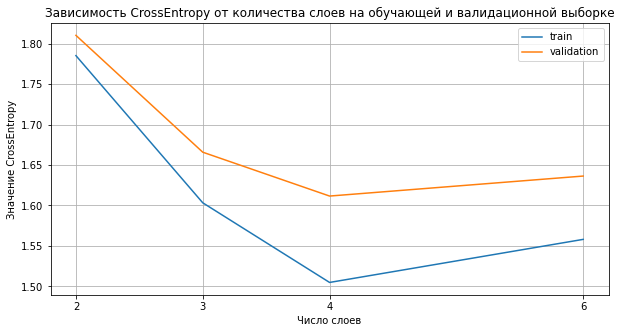

In [43]:
fig = plt.figure(figsize=(10, 5))

plt.plot(n_layers_arr, train_losses[-2,:, -1], label='train')
plt.plot(n_layers_arr, val_losses[-2,:, -1], label='validation')

plt.xlabel('Число слоев')
plt.ylabel('Значение CrossEntropy')
    
plt.xticks(n_layers_arr)

plt.title("Зависимость CrossEntropy от количества слоев на обучающей и валидационной выборке")
plt.legend()
plt.grid(True)
plt.show()

Можно наблюдать, что наименьшее значение кросс-энтропии на 4 слоях, поэтому считаем этот параметр лучшим

Попробуем перебрать различные значения вероятности дропаута

In [42]:
n_seqs = 128
n_steps = 100
drop_prob_arr = np.array([0, 0.1, 0.25, 0.5, 0.7])

In [41]:
train_losses = []
val_losses = []
for drop_prob in drop_prob_arr:
    net = LSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)
    train_loss, val_loss = train_model(net, corpus_array, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps,
                                               opt=opt, device=device)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])

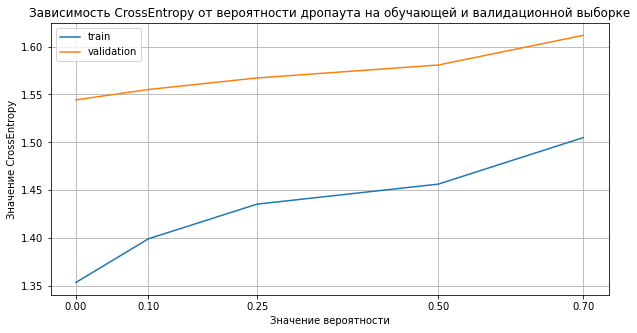

In [44]:
fig = plt.figure(figsize=(10, 5))

plt.plot(drop_prob_arr, train_losses[-2, -2], label='train')
plt.plot(drop_prob_arr, val_losses[-2, -2], label='validation')

plt.xlabel('Значение вероятности')
plt.ylabel('Значение CrossEntropy')

plt.xticks(drop_prob_arr)

plt.title("Зависимость CrossEntropy от вероятности дропаута на обучающей и валидационной выборке")
plt.legend()
plt.grid(True)
plt.show()

Можно наблюдать, что с увеличением вероятности дропаута кросс-энтропия растет. Это можно объяснить фиксированным количеством эпох. Поэтому дропаут не используем

Наконец, рассмотрим различные значения размерности скрытого представления

In [57]:
n_seqs = 128
n_steps = 100
n_hidden_arr = np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024])

In [58]:
train_losses = []
val_losses = []
for n_hidden in n_hidden_arr:
    net = LSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)
    train_loss, val_loss = train_model(net, corpus_array, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps,
                                               opt=opt, device=device)
    train_losses.append(train_loss[-1])
    val_losses.append(val_loss[-1])

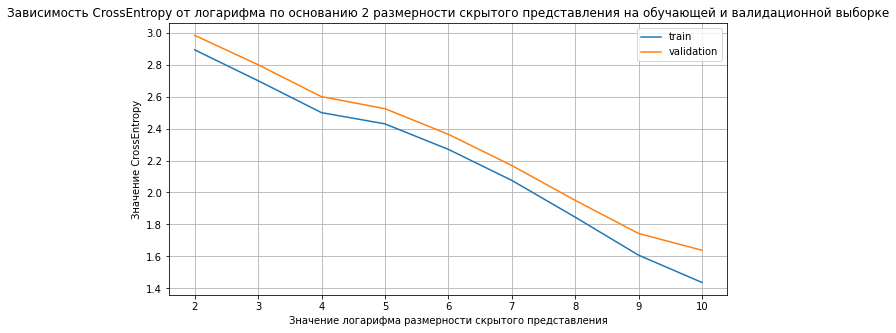

In [73]:
fig = plt.figure(figsize=(10, 5))

plt.plot(np.log2(n_hidden_arr), train, label='train')
plt.plot(np.log2(n_hidden_arr), val, label='validation')

plt.xlabel('Значение логарифма размерности скрытого представления')
plt.ylabel('Значение CrossEntropy')

plt.xticks(np.log2(n_hidden_arr))

plt.title("Зависимость CrossEntropy от логарифма по основанию 2 размерности скрытого представления на обучающей и валидационной выборке")
plt.legend()
plt.grid(True)
plt.show()

Таким образом, можно видеть, что с увеличением размерности, уменьшается кросс-энтропия. В свою очередь это приводит к значительному увеличению времени работы. Так, модель при 1024 n_hidden обучалась около 1 часа. В конце увеличение не такое большое, поэтому на этом можно прекратить повышение размерности.

## Генерация текста

В итоге модель будет обучаться на следующих гиперпараметрах: n_hidden = 1024, drop_prob=0, n_layers = 4, оптимизатор Adam. 

In [75]:
best_params = {"n_hidden":1024, "n_layers":4, "drop_prob":0}
best_params

{'n_hidden': 1024, 'n_layers': 4, 'drop_prob': 0}

In [76]:
net = LSTM(chars, **best_params)

In [77]:
n_seqs = 128
n_steps = 100

n_epochs = 30
opt = lambda x: torch.optim.Adam(x)

In [78]:
train_loss, val_loss = train_model(net, corpus_array, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps, opt=opt, device=device)

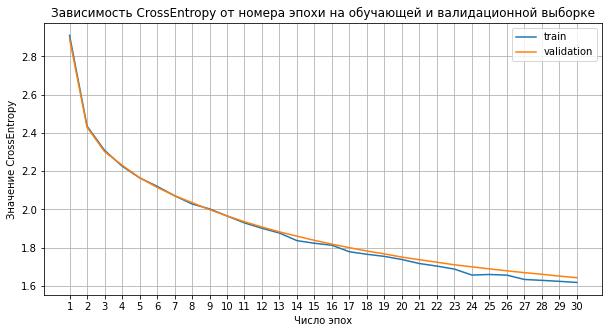

In [84]:
fig = plt.figure(figsize=(10, 5))

x = np.array(range(n_epochs)) + 1
plt.plot(x, train_loss, label='train')
plt.plot(x, val_loss, label='validation')

plt.xlabel('Число эпох')
plt.ylabel('Значение CrossEntropy')
    
plt.xticks(x)

plt.title("Зависимость CrossEntropy от номера эпохи на обучающей и валидационной выборке")
plt.legend()
plt.grid(True)
plt.show()

Видно, что значение кросс-энтропии чуть больше 1.6

In [85]:
model_name = 'best_model.pt'

In [86]:
checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'drop_prob': net.drop_prob,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(f'{model_name}', 'wb') as f:
    torch.save(checkpoint, f)

In [88]:
with open(f'{model_name}', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = LSTM(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'], drop_prob=checkpoint['drop_prob'])
loaded.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Попробуем с помощью top_k сэмплирования достичь хорошего результата при генерации

In [89]:
net = loaded

In [90]:
length = 500
prime = 'как только в школе'
k_arr = [None] + list(range(1, 11))

In [98]:
for k in k_arr:
    gen_text = sample(net, length, prime=prime, top_k=k, device=device)
    print(f'Top_k = {k}\n{gen_text}\n')

Top_k = None
как только в школеком месям стромательны отраз дворочами, троняешь, как у тобой, и откажившист я, временно плакнулось на последости порчанную споксили этот кон рукой дошки кондрата от пожадуем. он крути но шеквам, ждет могу, на это людим проч! хопровадцать. за по таким протачи людь мы в чимка теде могу парозанник хозой, а не всего содрижной дишли в меня, скажу была пялу пучтой тогда под подбросом било вот огромколь, тай против глаз до указал гетурю! а тот же кто скажешь, будта кобчате, и побчимий вымудить и должно

Top_k = 1
как только в школе не возле до подобрать с тобой подобрать в колхоз с тебя с тебя с него на столом, подобратился стоя в станицу просто сказать не стоял просилась по себе на кругов неторое старика, по приверенный принесили на собой веселось не под под ногу в поле себя не приездитель с тобой со старом старуха, старуха с тебе на себя с ней столок, не под под колхозников стал нагульнов под колхозному стал по себе не под конец, подобрали в колесовать под не

При малых top_k получается не очень, поэтому будем брать значения начиная с 3

In [100]:
length = 500
prime = 'расходились далеко за полночь'
k_arr = list(range(3, 6))

In [101]:
for k in k_arr:
    gen_text = sample(net, length, prime=prime, top_k=k, device=device)
    print(f'Top_k = {k}\n{gen_text}\n')

Top_k = 3
расходились далеко за полночью, андрей под кругом половцев, столом водруг с тебя надо сторонуть не совести по получем в коленких приехал до тогда с нас с него, как вы сталось в корони по себя не посторонет, на сторону под крыльца, с пахнет, подолго под кончате не под подобрать с табами послодне несколько принесть при под полевой советский колхоза предперавляем пальцами с домой советский пальцев, по корову с такого на собстоение по сторону на стороне страшногу на подуму станица просле поднял с нем по сверем с том, что парень,

Top_k = 4
расходились далеко за полночь на стольной последной приседенно в партию при своей стороженные как в кулаком. давыдов принесле на собой слышу, как на себя весь ты с теперь на казалось не восходите половцев, сказался: давай продержения сталаный предстремнить, а под печету то по мне строгованов так он в колхоз принед стаком, но выселей кровь из сам сверение, на держаты под почти в станову, чтобы на кружине ни когда по сверту весельников подним пер

## Выводы

Была создана языковая модель на базе LSTM с посимвольным кодированием, для обучения использовался романе классиков современного русского языка. Были подобраны лучшие гиперпараметры модели, обеспечивающие наибольшее качество решения (для оценки использовалась кросс-энтропия). И при оптимальных параметрах сэмплирования генерируемый текст получается читаемым, достаточно осмысленным и почти без несуществующих слов.